# Import Libraries

In [1]:
import math
import warnings
from glob import glob
from itertools import repeat
from os.path import join
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from geopandas import read_file
from IPython.display import display, Image
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
sns.set()

DEBUG = True
SAVE_FILE = False

# NOTE: remove in production
# autoreload reloads modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

## Importing Datasets

The dataset was using from

In [2]:
# Parse df to the function
df = pd.read_csv("./data/amazon.csv", encoding="ISO-8859-1", thousands=".")
display(df.head())

year state    month  number        date
0  1998  Acre  Janeiro       0  1998-01-01
1  1999  Acre  Janeiro       0  1999-01-01
2  2000  Acre  Janeiro       0  2000-01-01
3  2001  Acre  Janeiro       0  2001-01-01
4  2002  Acre  Janeiro       0  2002-01-01

In [3]:
# Read map data: shape file for Brazil
map_df = read_file("./data/brazil-shapefile/Central-West Region_AL3-AL4.shp")
map_df = map_df.iloc[5:, :]
display(map_df.head())

id country      name    enname   locname offname        boundary  \
5  326266     BRA      Acre      Acre      Acre    None  administrative   
6  303781     BRA   Alagoas   Alagoas   Alagoas    None  administrative   
7  331463     BRA    AmapÃ¡    AmapÃ¡    AmapÃ¡    None  administrative   
8  332476     BRA  Amazonas  Amazonas  Amazonas    None  administrative   
9  362413     BRA     Bahia     Bahia     Bahia    None  administrative   

   adminlevel wikidata    wikimedia            timestamp  note  \
5           4   Q40780      pt:Acre  2018-09-13 03:11:44  None   
6           4   Q40885   pt:Alagoas  2018-09-13 03:11:43  None   
7           4   Q40130    pt:AmapÃ¡  2018-09-13 03:11:43  None   
8           4   Q40040  pt:Amazonas  2018-09-13 03:11:43  None   
9           4   Q40430     pt:Bahia  2018-09-13 03:11:43  None   

                    rpath ISO3166_2  \
5  326266,3360778,59470,0     BR-AC   
6  303781,3360429,59470,0     BR-AL   
7  331463,3360778,59470,0     BR-AP   
8  332476,3360778,59470,0     BR-AM   
9  362413,3360429,59470,0     BR-BA   

                                            geometry  
5  POLYGON ((-73.9830625 -7.5347344, -73.98303319...  
6  (POLYGON ((-35.7878322 -9.6739446, -35.7879395...  
7  (POLYGON ((-49.9093374 1.2355118, -49.9098495 ...  
8  POLYGON ((-73.7984196 -7.113061, -73.7979581 -...  
9  (POLYGON ((-38.8990898 -13.2047832, -38.899352...

## Understanding Data Structure

In [4]:
if DEBUG:
    print("1. The data has " + str(df.shape[0]) + " rows, and " + str(df.shape[1]) + " columns\n\n")
    print("2. Overview on the data type of each column: \n")
    df.info()
    print("\n")
    print("3. Check for Missing Values: \n")
    print(df.isna().sum())  # check for Na
    print("\n\n")
    print("4. Descriptive statistics on the int64 columns:\n")
    print(df.describe())
    print("\n\n")
    print("5. Number of levels for the categorical variables: \n")
    print("month column has " + str(df["month"].nunique()) + " levels")
    print("state column has " + str(df["state"].nunique()) + " levels")

1. The data has 6454 rows, and 5 columns


2. Overview on the data type of each column: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 5 columns):
year      6454 non-null int64
state     6454 non-null object
month     6454 non-null object
number    6454 non-null int64
date      6454 non-null object
dtypes: int64(2), object(3)
memory usage: 252.2+ KB


3. Check for Missing Values: 

year      0
state     0
month     0
number    0
date      0
dtype: int64



4. Descriptive statistics on the int64 columns:

              year        number
count  6454.000000   6454.000000
mean   2007.461729    522.696312
std       5.746654   1554.846486
min    1998.000000      0.000000
25%    2002.000000      9.000000
50%    2007.000000     54.000000
75%    2012.000000    269.000000
max    2017.000000  25963.000000



5. Number of levels for the categorical variables: 

month column has 12 levels
state column has 23 levels


## Data Cleaning
### 1. Date: Possible Duplicate Column
Check if *date* is a duplicated column with *year*

In [5]:
year = df.iloc[:, 0]
date = df.iloc[:, -1]
date = date.str.extract(r"(\d+)") # Extract year from date
date = date.iloc[:, 0]            # Transform to Series type
date = date.astype(year.dtype)    # Convert String to int

not_same = (date != year)
if not not_same.any() :
    print(" -- All years in date column is same as year column")
else :
    print(" -- Atleast one row that the year of date column is different with year column")

 -- All years in date column is same as year column


In [6]:
# Check if month & day is all equal 1
date = df.iloc[:, -1]
date = date.str.extract(r"-(\d+)-(\d+)") # Extract month & day from date
date = date.applymap(int)                # Convert String to int
date.columns = ["month", "day"]
not1 = date != 1
print("Is there any column is not all equal to 1?\n")
print(not1.any())
print("\n -- All values in month and day are 1")


Is there any column is not all equal to 1?

month    False
day      False
dtype: bool

 -- All values in month and day are 1


Since:  
1. All years in date column is same as year column  
2. All values in month and day are 1

Therefore:  
-- The *date* column is duplicated, hence it is allowed to drop the *date* column

In [7]:
df = df.iloc[:, 0:4]
display(df)

year      state     month  number
0     1998       Acre   Janeiro       0
1     1999       Acre   Janeiro       0
2     2000       Acre   Janeiro       0
3     2001       Acre   Janeiro       0
4     2002       Acre   Janeiro       0
...    ...        ...       ...     ...
6449  2012  Tocantins  Dezembro     128
6450  2013  Tocantins  Dezembro      85
6451  2014  Tocantins  Dezembro     223
6452  2015  Tocantins  Dezembro     373
6453  2016  Tocantins  Dezembro     119

[6454 rows x 4 columns]

### 2. Deal with time column
portugese month & numeric year -> period object in pandas

In [8]:
month_por =  df.iloc[:, 2].unique()
print(month_por)

['Janeiro' 'Fevereiro' 'Março' 'Abril' 'Maio' 'Junho' 'Julho' 'Agosto'
 'Setembro' 'Outubro' 'Novembro' 'Dezembro']


In [9]:
month_num = list(range(1, 13))
foo = pd.DataFrame({"month": month_por, "mmm": month_num})
df = pd.merge(df, foo, on="month", how="left")
df["period"] = df.apply(lambda t: pd.Period(
    year=t["year"], month=t["mmm"], freq="M"), axis=1)
df = df[["period", "state", "number"]]
display(df)

period      state  number
0     1998-01       Acre       0
1     1999-01       Acre       0
2     2000-01       Acre       0
3     2001-01       Acre       0
4     2002-01       Acre       0
...       ...        ...     ...
6449  2012-12  Tocantins     128
6450  2013-12  Tocantins      85
6451  2014-12  Tocantins     223
6452  2015-12  Tocantins     373
6453  2016-12  Tocantins     119

[6454 rows x 3 columns]

### 3. Duplicate Data
Detect the duplication by counting the entries

In [10]:
df["state"].value_counts()

Rio                 717
Paraiba             478
Mato Grosso         478
Alagoas             240
Goias               239
Rondonia            239
Bahia               239
Piau                239
Espirito Santo      239
Sergipe             239
Pará                239
Acre                239
Amazonas            239
Ceara               239
Distrito Federal    239
Maranhao            239
Tocantins           239
Santa Catarina      239
Roraima             239
Pernambuco          239
Minas Gerais        239
Amapa               239
Sao Paulo           239
Name: state, dtype: int64

Most of the states have 239 entries, so there may exist some duplicate entries.  
For those states which have more than 239 entries: Rio, Paraiba, Mato Grosso, Alagoas

Hence we check on the number of states between *map_df* and *df*

In [11]:
state_por = map_df.iloc[:, 2]
state_eng = df.iloc[:, 2].unique()
if len(state_por) != len(state_eng) :
    print("map_df and df have different length of states")

map_df and df have different length of states


By comparing with state_por, the following entries are label wrongly:  
Rio <- Rio de Janeiro  
Rio <- Rio Grande do Norte  
Rio <- Rio Grande do Sul  
Mato Grosso <- Mato Grosso  
Mato Grosso <- Mato Grosso do Sul  
Paraiba <- ParaÃ­ba  
Paraiba <- ParanÃ¡  
Hence the actual count of entry for these state are stated below:  
Rio &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = 239 \* 3 = 717  
Mato Grosso                                    = 239 \* 2 = 478  
Paraiba &nbsp;&nbsp;&nbsp;                     = 239 \* 2 = 478

The only duplication occured in Alagoas:

In [12]:
d = df[df.state == "Alagoas"]
duplication = d[d.duplicated()]
index = duplication.index
display(duplication)

period    state  number
259  2017-01  Alagoas      38

Check for deletion:

In [13]:
df = df.drop(index=index, axis=1)
df["state"].value_counts()

Rio                 717
Paraiba             478
Mato Grosso         478
Goias               239
Rondonia            239
Bahia               239
Piau                239
Espirito Santo      239
Sergipe             239
Pará                239
Acre                239
Amazonas            239
Ceara               239
Distrito Federal    239
Alagoas             239
Maranhao            239
Tocantins           239
Santa Catarina      239
Roraima             239
Pernambuco          239
Minas Gerais        239
Amapa               239
Sao Paulo           239
Name: state, dtype: int64

### 4. State: Replace with actual portugese state name
Check for order of states in *df* and *map_df*

In [14]:
print(df.state.unique())

['Acre' 'Alagoas' 'Amapa' 'Amazonas' 'Bahia' 'Ceara' 'Distrito Federal'
 'Espirito Santo' 'Goias' 'Maranhao' 'Mato Grosso' 'Minas Gerais' 'Pará'
 'Paraiba' 'Pernambuco' 'Piau' 'Rio' 'Rondonia' 'Roraima' 'Santa Catarina'
 'Sao Paulo' 'Sergipe' 'Tocantins']


In [15]:
print(state_por.tolist())

['Acre', 'Alagoas', 'AmapÃ¡', 'Amazonas', 'Bahia', 'CearÃ¡', 'EspÃ\xadrito Santo', 'Federal District', 'GoiÃ¡s', 'MaranhÃ£o', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'ParÃ¡', 'ParaÃ\xadba', 'ParanÃ¡', 'Pernambuco', 'PiauÃ\xad', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 'RondÃ´nia', 'Roraima', 'Santa Catarina', 'SÃ£o Paulo', 'Sergipe', 'Tocantins']


Found inconsistent order in df.state compared to state_por:  
1. The order for Rio, Mato Grosso and Paraiba was assumed followed alphabetical order  
2. The order EspÃ­rito Santo & Federal District should be reversed

In [16]:
index = list(range(27))
index[6], index[7] = index[7], index[6]
state_por = state_por.iloc[index]

df.state = [x for item in state_por for x in repeat(item, 239)]
display(df)

period      state  number
0     1998-01       Acre       0
1     1999-01       Acre       0
2     2000-01       Acre       0
3     2001-01       Acre       0
4     2002-01       Acre       0
...       ...        ...     ...
6449  2012-12  Tocantins     128
6450  2013-12  Tocantins      85
6451  2014-12  Tocantins     223
6452  2015-12  Tocantins     373
6453  2016-12  Tocantins     119

[6453 rows x 3 columns]

## Map Visualisation
### 1. Data Wrangling

In [17]:
wide_df = df.copy()
wide_df["year"] = wide_df.period.map(lambda t: t.year)
wide_df = wide_df.groupby(["year", "state"])
wide_df = wide_df.sum().unstack(level=0)
wide_df.columns = wide_df.columns.droplevel()
wide_df = wide_df.reset_index()

display(wide_df.head())

year     state  1998  1999  2000  2001   2002   2003   2004   2005  2006  ...  \
0         Acre   730   333   434   828   3491   6859   3160   9427  1456  ...   
1      Alagoas    86   172   123    86    258    299    159    217   161  ...   
2       AmapÃ¡   278   101   253  1301   1957   1652   2261   1271   817  ...   
3     Amazonas   946  1061   853  1297   2852   4789   3504   6780  4634  ...   
4        Bahia  5907  3777  3993  8073  16048  17212  10423  16410  7589  ...   

year   2008  2009   2010   2011   2012  2013  2014   2015   2016   2017  
0      2808  2095   4684   1912   3180  3242  2740   5512   6993   7042  
1       277   325    222    232    352   208   190    590    400    121  
2       785  2127    721   1100   2103   975  1490   1366   2653   1465  
3      2717  7915   8826   4188   7745  5118  9288  15170  12023  14798  
4     17600  5092  15512  13061  17378  7217  7819  18397   6751   8249  

[5 rows x 21 columns]

### 2. Plot map

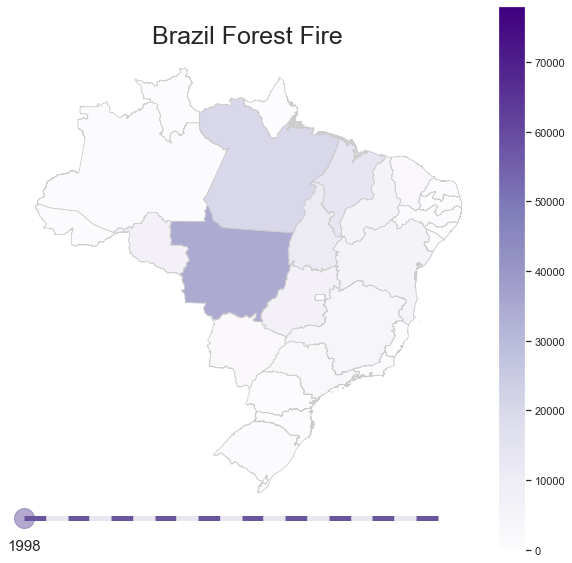

In [18]:
# Try plot map with 1 example
if DEBUG:
    left = map_df.copy()
    right = wide_df.copy().iloc[:,0:2]
    right.rename(columns={"state" : "name"}, inplace=True)
    plot_df = pd.merge(left, right, on="name", how="left")

    vmin = wide_df.iloc[:,1:].min().min()
    vmin = int(math.floor(vmin/1000))*1000
    vmax = wide_df.iloc[:,1:].max().max()
    vmax = int(math.ceil(vmax/1000))*1000

    year = 1998
    fig = plot_df.plot(column=year, cmap="Purples", figsize=(10, 10), linewidth=0.8, edgecolor="0.8", vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    fig.axis("off")
    fig.set_title('Brazil Forest Fire', fontdict={'fontsize': '25', 'fontweight' : '3'})

    x_coord = 2 * year - 4071
    fig.plot(x_coord, -36, "o", color="#69549E", markersize=20, alpha=0.5, clip_on=False, zorder=100)
    fig.text(x_coord, -39, str(year), horizontalalignment="center", fontsize=15)

    plt.ylim(-35,7)
    plt.xlim(-75,-34)

    for n in range(1, 20) :
        x_coord = -75 + (n - 1) * 2
        color = '#69549E' if n % 2 else '#E8E7EF'
        plt.hlines(-36, x_coord, x_coord + 2, colors=color, lw=5, clip_on=False, zorder=100)

    plt.show()

In [19]:
# Plot multiple maps
if SAVE_FILE:
    left = map_df.copy()
    right = wide_df.copy()
    right.rename(columns={"state" : "name"}, inplace=True)
    plot_df = pd.merge(left, right, on="name", how="left")

    vmin = wide_df.iloc[:,1:].min().min()
    vmin = int(math.floor(vmin/1000))*1000
    vmax = wide_df.iloc[:,1:].max().max()
    vmax = int(math.ceil(vmax/1000))*1000

    year_list = wide_df.columns[1:]

    for year in year_list:
        fig = plot_df.plot(column=year, cmap="Purples", figsize=(10, 10), linewidth=0.8, edgecolor="0.8", vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        
        fig.axis("off")
        fig.set_title('Brazil Forest Fire', fontdict={'fontsize': '25', 'fontweight' : '3'})
        
        x_coord = 2 * year - 4071
        fig.plot(x_coord, -36, "o", color="#69549E", markersize=20, alpha=0.5, clip_on=False, zorder=100)
        fig.text(x_coord, -39, str(year), horizontalalignment="center", fontsize=15)

        plt.ylim(-35,7)
        plt.xlim(-75,-34)

        for n in range(1, 20):
            x_coord = -75 + (n - 1) * 2
            color = '#69549E' if n % 2 else '#E8E7EF'
            plt.hlines(-36, x_coord, x_coord + 2, colors=color, lw=5, clip_on=False, zorder=100)

        filepath = join("maps", str(year)+'.png')
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=300)

        plt.close()

    print("done")

In [20]:
# Output images to Gif using image magick
if SAVE_FILE:
    imgs = glob('*.png')

    cmd = ['magick','convert', '-loop', '0', '-delay', '40'] + imgs + ['magicksmap.gif']
    call(cmd)

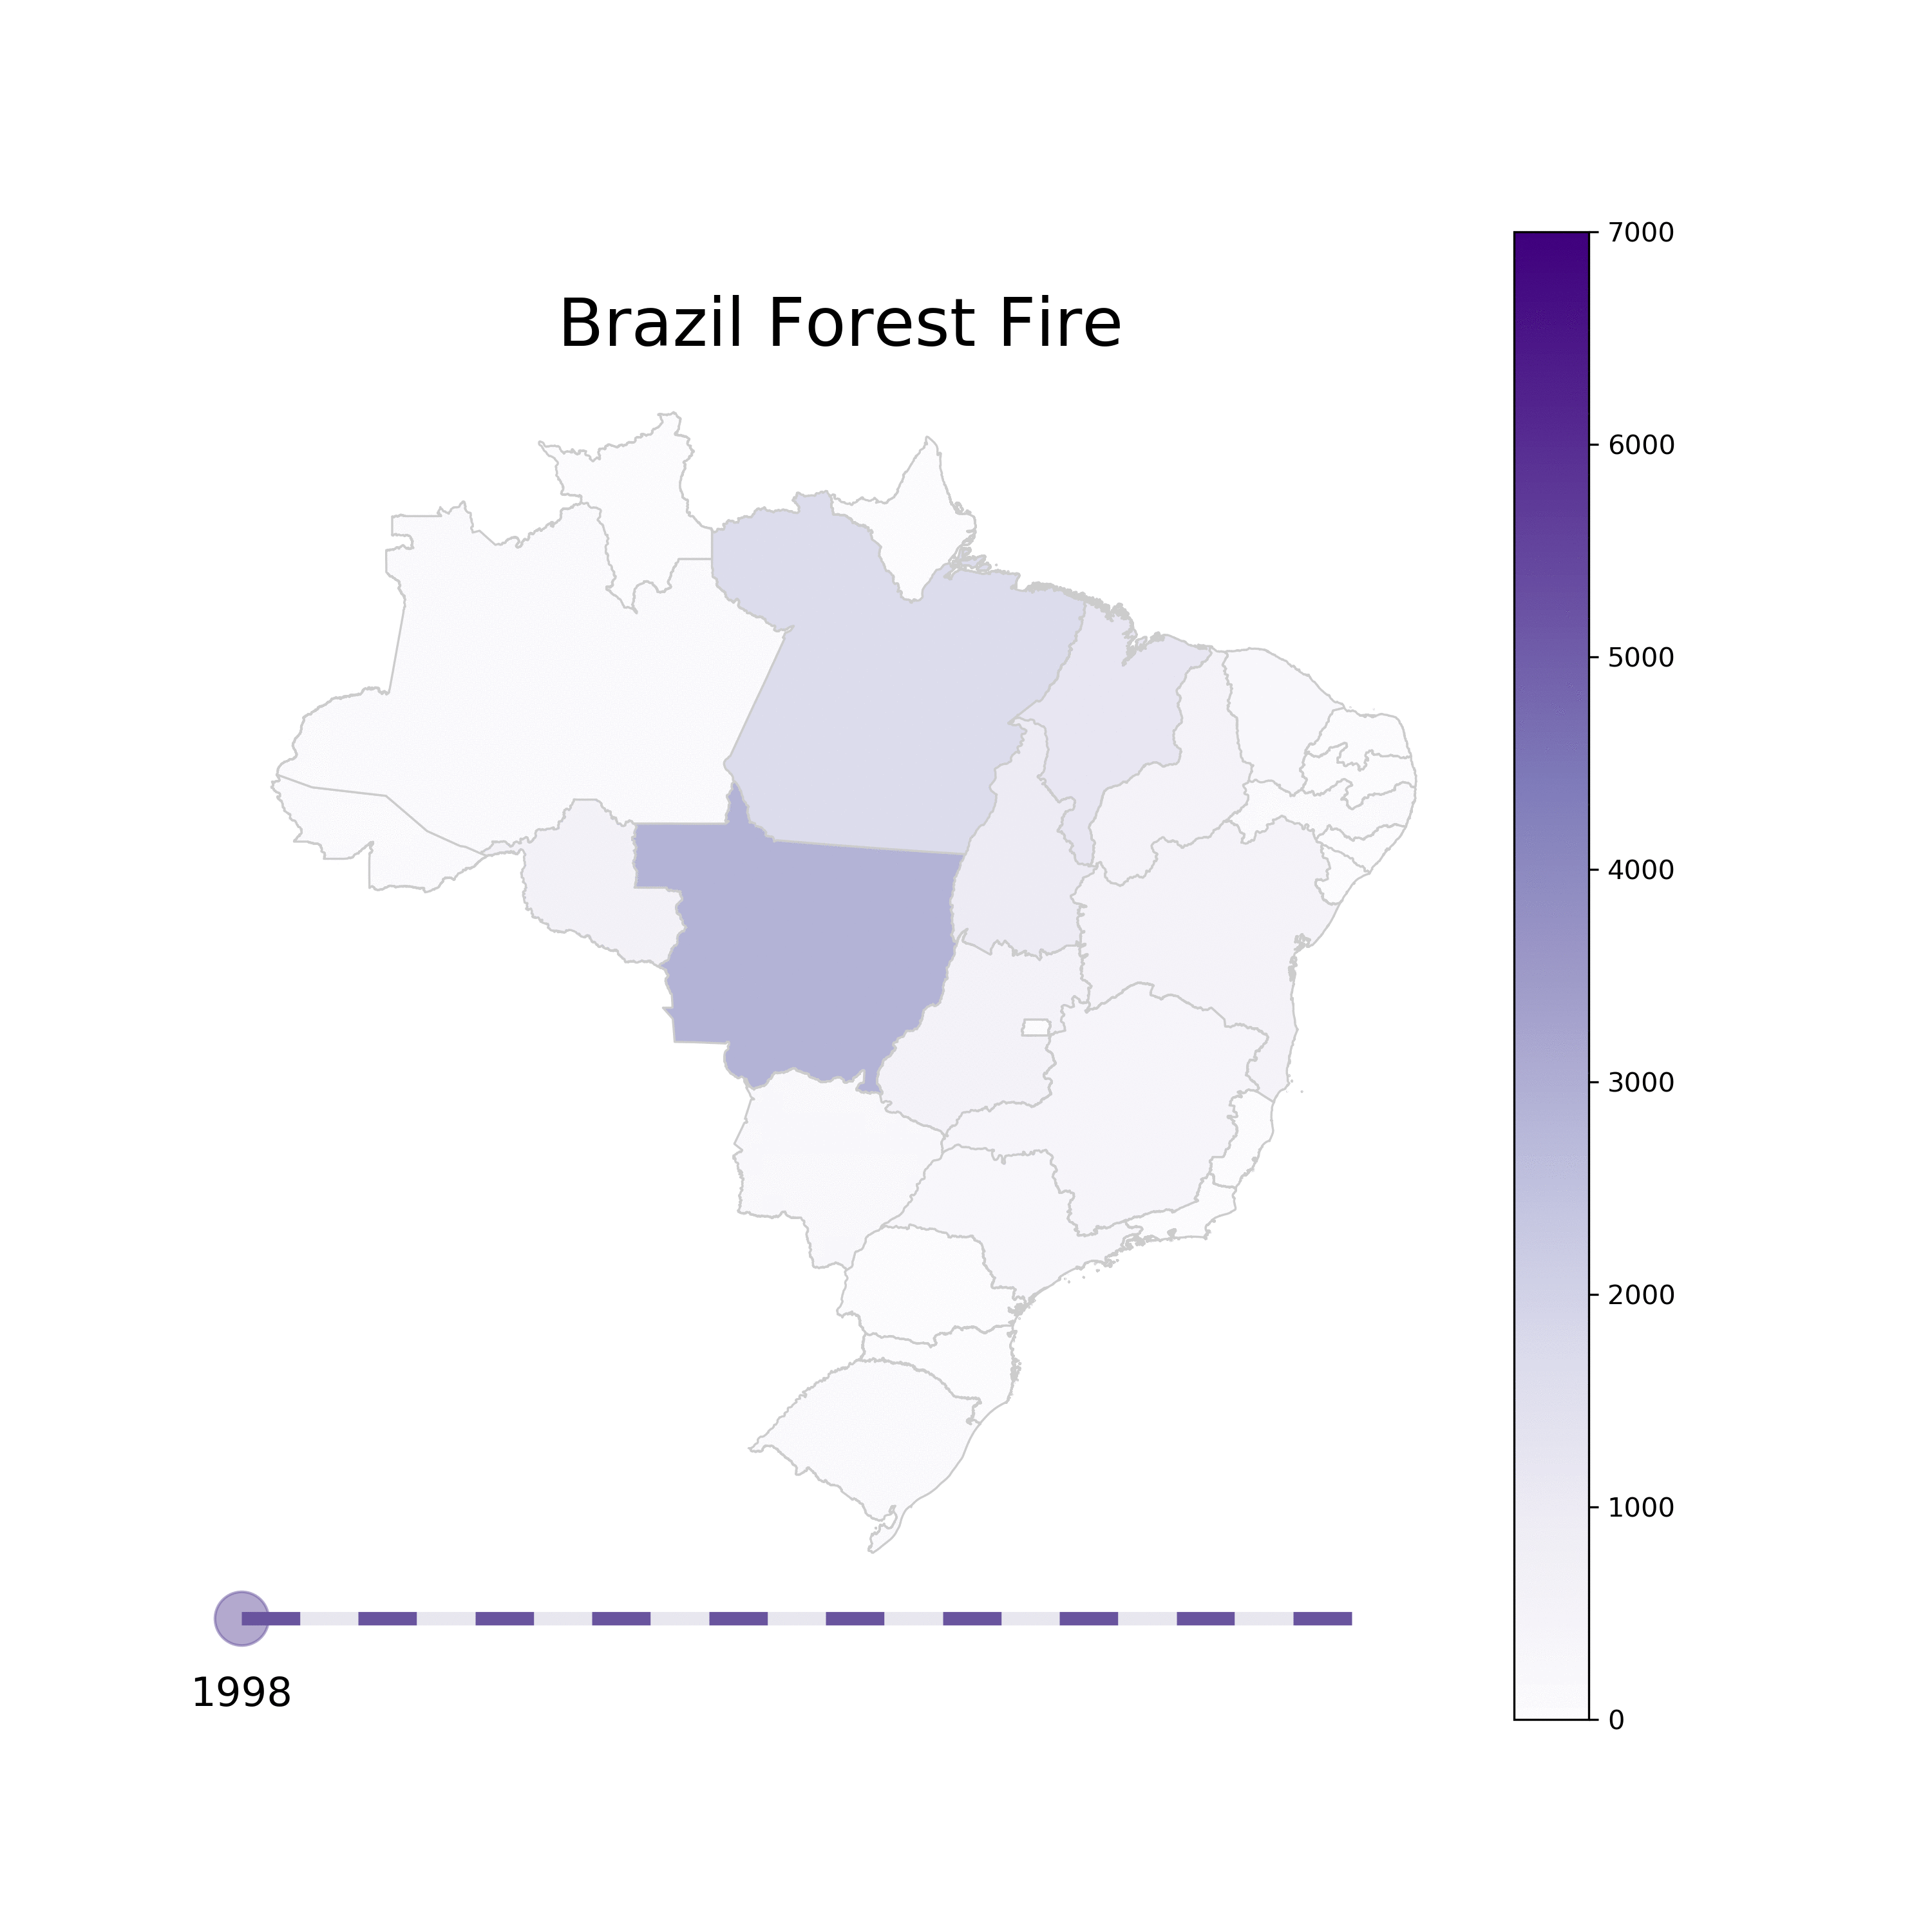

In [21]:
path = './maps/magicksmap.gif'

with open(path, 'rb') as file:
    display(Image(file.read()))

## Data Visualization
### Finalizing Data Cleaning

In [22]:
df = df.groupby(["period"]).sum()

if SAVE_FILE:
    df.to_csv(r'testing.csv')

### 1. Decomposition Plot

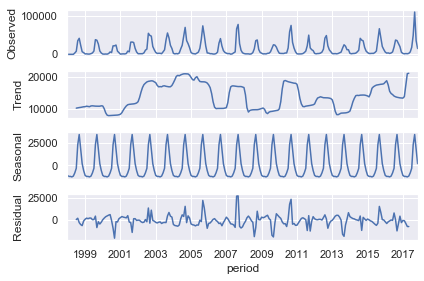

In [23]:
result = seasonal_decompose(df, model='additive', freq=12)
result.plot()
plt.show()

### 2. Plot of forest fire

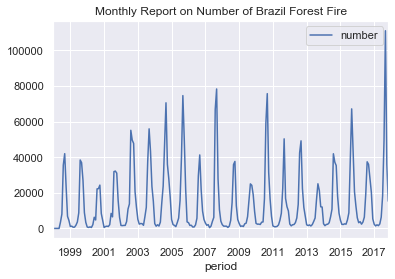

In [24]:
df.groupby(["period"]).sum().plot()
plt.title("Monthly Report on Number of Brazil Forest Fire")
plt.show()

### 2. Table form

In [25]:
wide_df = df.copy().reset_index()
wide_df["year"] = wide_df.period.map(lambda t: t.year)
wide_df["month"] = wide_df.period.map(lambda t: t.month)
wide_df = wide_df.groupby(["year", "month"])
wide_df = wide_df.sum().unstack()
wide_df.columns = wide_df.columns.droplevel()

display(wide_df)

month      1       2       3       4       5        6        7        8   \
year                                                                       
1998      0.0     0.0     0.0     0.0     0.0   3551.0   8066.0  35549.0   
1999   1081.0  1284.0   667.0   717.0  1812.0   3632.0   8756.0  38415.0   
2000    778.0   561.0   848.0   537.0  2097.0   6275.0   4739.0  22202.0   
2001    547.0  1059.0  1268.0  1081.0  2090.0   8433.0   6490.0  31887.0   
2002   1654.0  1570.0  1679.0  1682.0  3818.0  10839.0  13751.0  55099.0   
2003   5091.0  2398.0  2749.0  2677.0  1747.0   6506.0  11804.0  37382.0   
2004   2705.0  1255.0  2040.0  1335.0  3535.0  14262.0  23809.0  48038.0   
2005   4990.0  2153.0  1706.0  1011.0  3210.0   5811.0  15663.0  39912.0   
2006   3255.0  1666.0  1774.0   792.0   808.0   1968.0   5722.0  29443.0   
2007   3055.0  1751.0  2136.0   415.0  1286.0   3956.0   6197.0  66837.0   
2008   2125.0  1275.0  1239.0  1253.0   553.0   1287.0   4507.0  14528.0   
2009   2848.0  1140.0  1392.0  1078.0  2593.0   2962.0   6599.0  15534.0   
2010   2851.0  2386.0  2417.0  2200.0  3497.0   3642.0  16646.0  58985.0   
2011   1416.0   973.0   937.0  1152.0  1985.0   4578.0   8524.0  22477.0   
2012   2491.0  1436.0  2058.0  2193.0  3240.0   5890.0  13507.0  42422.0   
2013   2045.0  1587.0  1969.0  1372.0  2165.0   3898.0   5843.0  16143.0   
2014   2633.0  1547.0  2224.0  2358.0  3189.0   6483.0  10801.0  41928.0   
2015   4635.0  2309.0  2202.0  2573.0  2384.0   4775.0   8752.0  37167.0   
2016   5979.0  3202.0  3796.0  2379.0  3568.0   6339.0  19141.0  37408.0   
2017   2370.0  1400.0  2017.0  1559.0  2506.0   6318.0  18303.0  49485.0   

month        9        10       11       12  
year                                        
1998    41968.0  23495.0   6804.0   4448.0  
1999    36913.0  27012.0   8860.0   3377.0  
2000    22319.0  24321.0   8399.0   4465.0  
2001    32193.0  31038.0  15639.0   6201.0  
2002    49566.0  47722.0  20691.0  11944.0  
2003    55913.0  43295.0  23572.0  15342.0  
2004    70531.0  36002.0  27892.0  17524.0  
2005    74574.0  49876.0  21752.0   3636.0  
2006    41264.0  21854.0   9754.0   5027.0  
2007    78299.0  27911.0  10494.0   4075.0  
2008    35836.0  37617.0  12778.0   4995.0  
2009    25002.0  24202.0  18919.0   9494.0  
2010    75679.0  31485.0  16584.0   6856.0  
2011    50301.0  16879.0  12221.0   9828.0  
2012    49183.0  22333.0  11777.0   6823.0  
2013    25069.0  21325.0  12150.0  12006.0  
2014    37225.0  35320.0  17989.0   8562.0  
2015    67124.0  44138.0  20590.0  12647.0  
2016    35978.0  27843.0  20153.0   5346.0  
2017   110988.0  35997.0  15308.0      NaN

### 3. Overall trend

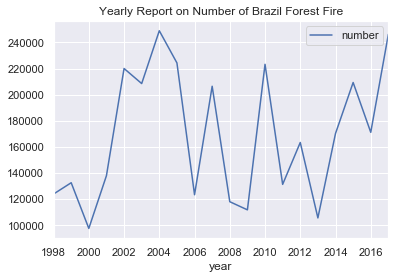

In [26]:
by_year = df.copy().reset_index()
by_year["year"] = by_year.period.map(lambda t: t.year)
by_year = by_year.groupby(["year"]).sum().plot()
plt.title("Yearly Report on Number of Brazil Forest Fire")
plt.xticks(np.arange(1998, 2017, 2))
plt.show()

### 4. Seasonal of forest fire

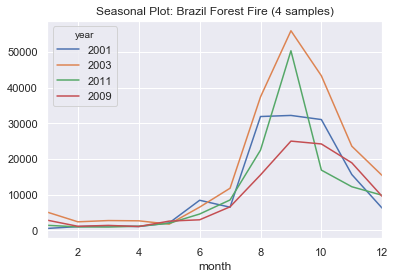

In [27]:
seed = 111
wide_df.sample(n=4, random_state=seed).T.plot()
plt.title("Seasonal Plot: Brazil Forest Fire (4 samples)")
plt.show()

### 5. ACF plot / PACF plot (Correlogram)

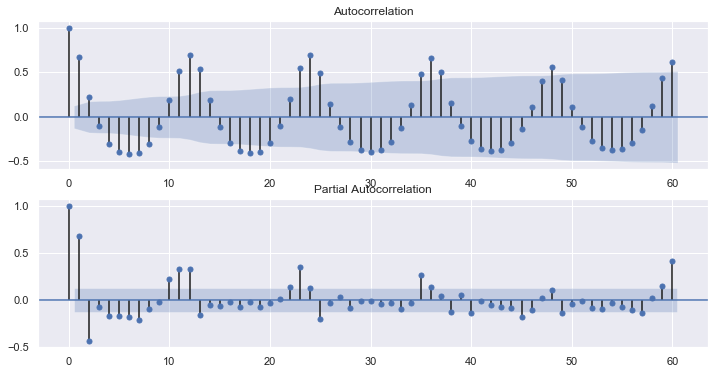

In [28]:
fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0] = plot_acf(df, ax=ax[0], lags=60)
ax[1] = plot_pacf(df, ax=ax[1], lags=60)
plt.show()

## Data Modelling
### Train-Test Split

In [29]:
split_index = pd.Period("2016-12", "M")

### Error Measurement: MSE

In [30]:
def MSE(a):
    return np.square(np.subtract(a["y_t"], a["F_t"])).mean()

error = pd.DataFrame(columns = ["method", "test", "train"])

### 1. Seasonal Naive

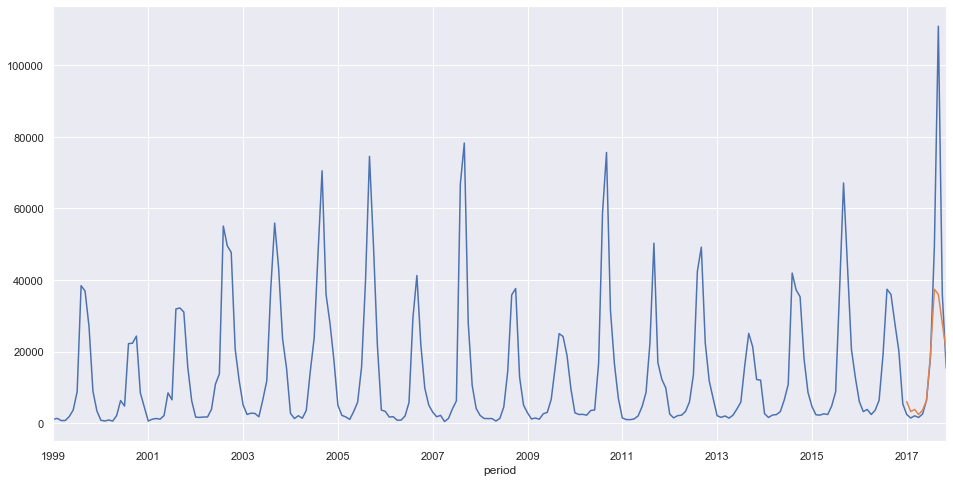

In [31]:
new_df = df.copy()
new_df.columns = ["y_t"]
new_df["F_t"] = new_df["y_t"].shift(12)
new_df = new_df.dropna()

train = new_df[:split_index.strftime("%Y-%m")]
test = new_df[(split_index+1).strftime("%Y-%m"):]
plt.figure(figsize=(16, 8))
new_df["y_t"].plot(label="Original Data")
test["F_t"].plot(label="Seasonal Naive")
plt.show()

In [32]:
method = "Seasonal Naive"
if method in error["method"].values:
    error = error[error.method != method]
error = error.append(dict(method=method, train=MSE(train),
                          test=MSE(test)), ignore_index=True)

### 2. Exponential Smoothing: Holt-Winter's

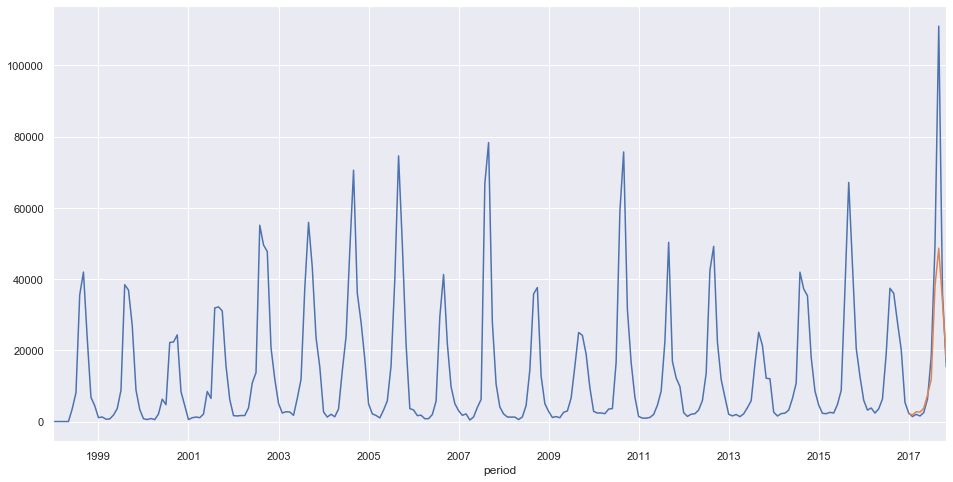

In [33]:
new_df = df.copy()
new_df.columns = ["y_t"]

train = new_df[:split_index.strftime("%Y-%m")]
test = new_df[(split_index+1).strftime("%Y-%m"):]

fit1 = ExponentialSmoothing(np.asarray(
    train['y_t']), seasonal_periods=12, trend='add', seasonal='add',).fit()

train["F_t"] = fit1.fittedvalues
test["F_t"] = fit1.forecast(len(test))

plt.figure(figsize=(16, 8))
new_df["y_t"].plot()
test["F_t"].plot()
plt.show()

In [34]:
print(fit1.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                    11290317671.676
Optimized:                         True   AIC                           4071.673
Trend:                         Additive   BIC                           4126.543
Seasonal:                      Additive   AICC                          4074.946
Seasonal Periods:                    12   Date:                 Thu, 14 Nov 2019
Box-Cox:                          False   Time:                         20:19:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6046842                alpha                 True
smoothing_slope          

In [35]:
method = "Holt-Winter's"
if method in error["method"].values:
    error = error[error.method != method]
error = error.append(dict(method=method, train=MSE(train),test=MSE(test)), ignore_index=True)

### 3. Decomposition Method

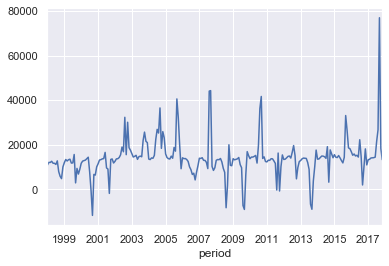

In [36]:
new_df = df.copy()
new_df.columns = ["y_t"]

train = new_df[:split_index.strftime("%Y-%m")]
test = new_df[(split_index+1).strftime("%Y-%m"):]

deseasonal = new_df.iloc[:, 0] - result.seasonal.iloc[:, 0]

deseasonal.plot()
plt.show()

In [37]:
train.loc[:, "deseasonal"] = deseasonal[:split_index.strftime("%Y-%m")]
fit2 = OLS(train["deseasonal"], add_constant(range(len(train)))).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deseasonal   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5140
Date:                Thu, 14 Nov 2019   Prob (F-statistic):              0.474
Time:                        20:19:41   Log-Likelihood:                -2360.2
No. Observations:                 228   AIC:                             4724.
Df Residuals:                     226   BIC:                             4731.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.309e+04   1004.788     13.030      0.000    1.11e+04    1.51e+04
x1             5.4903      7.658      0.717      0.474      -9.601      20.581
==============================================================================
Omnibus:                       46.927   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.797
Skew:                           0.666   Prob(JB):                     1.03e-51
Kurtosis:                       7.790   Cond. No.                         262.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

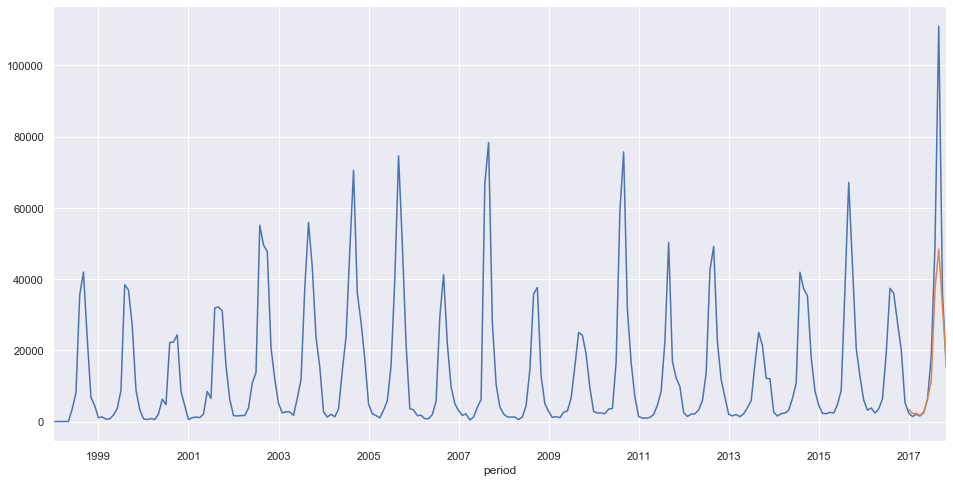

In [38]:
train["F_t"] = fit2.fittedvalues + result.seasonal.iloc[:len(train), 0]
test["F_t"] = fit2.predict(add_constant(
    range(len(train), len(new_df)))) + result.seasonal.iloc[len(train):, 0]

plt.figure(figsize=(16, 8))
new_df["y_t"].plot()
test["F_t"].plot()
plt.show()

In [39]:
method = "Decomposition"
if method in error["method"].values:
    error = error[error.method != method]
error = error.append(dict(method=method, train=MSE(train),test=MSE(test)), ignore_index=True)

### 4. Time Series Regression

In [40]:
new_df = df.copy()
new_df.columns = ["y_t"]

dummies = pd.get_dummies(df.index.month, drop_first=True)
dummies["t"] = range(len(df))
dummies.index = new_df.index

train = new_df[:split_index.strftime("%Y-%m")]
test = new_df[(split_index+1).strftime("%Y-%m"):]
train_dummy = dummies[:split_index.strftime("%Y-%m")]
test_dummy = dummies[(split_index+1).strftime("%Y-%m"):]

fit3 = OLS(train, add_constant(train_dummy)).fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_t   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     72.37
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           1.43e-68
Time:                        20:19:42   Log-Likelihood:                -2360.2
No. Observations:                 228   AIC:                             4746.
Df Residuals:                     215   BIC:                             4791.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2042.7171   1980.962      1.031      0.304   -1861.875    5947.309
2          -1091.1712   2531.192     -0.431      0.667   -6080.300    3897.958
3           -909.9214   2531.229     -0.359      0.720   -5899.123    4079.280
4          -1246.8295   2531.290     -0.493      0.623   -6236.151    3742.492
5           -369.6323   2531.375     -0.146      0.884   -5359.122    4619.858
6           2862.1965   2531.485      1.131      0.259   -2127.510    7851.903
7           7816.1305   2531.619      3.087      0.002    2826.159    1.28e+04
8           3.371e+04   2531.778     13.314      0.000    2.87e+04    3.87e+04
9           4.494e+04   2531.961     17.750      0.000       4e+04    4.99e+04
10          2.855e+04   2532.168     11.277      0.000    2.36e+04    3.35e+04
11          1.294e+04   2532.400      5.108      0.000    7944.619    1.79e+04
12          5329.4322   2532.656      2.104      0.037     337.417    1.03e+04
t              5.5397      7.861      0.705      0.482      -9.955      21.034
==============================================================================
Omnibus:                       48.664   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.618
Skew:                           0.704   Prob(JB):                     5.63e-53
Kurtosis:                       7.832   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

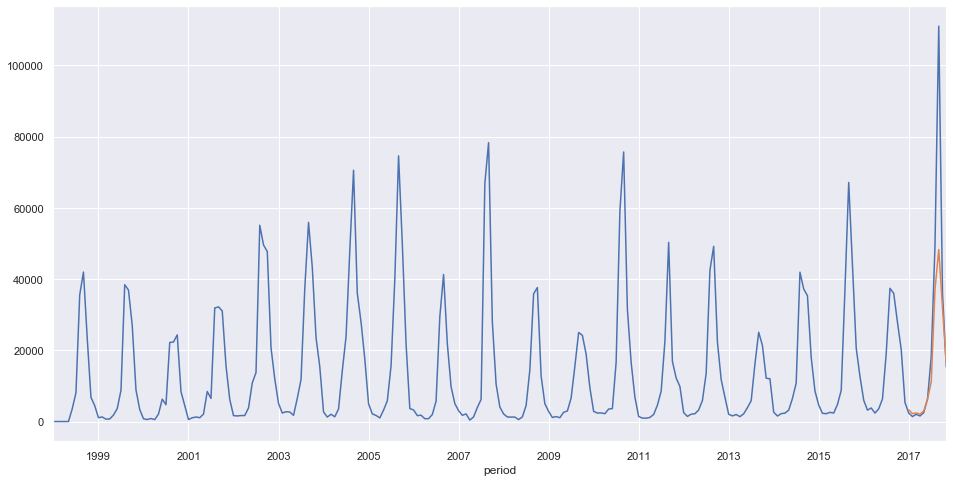

In [41]:
train["F_t"] = fit3.fittedvalues
test["F_t"] = fit3.predict(add_constant(test_dummy))

plt.figure(figsize=(16, 8))
new_df["y_t"].plot()
test["F_t"].plot()
plt.show()

In [42]:
method = "Time-Series Regression"
if method in error["method"].values:
    error = error[error.method != method]
error = error.append(dict(method=method, train=MSE(train),test=MSE(test)), ignore_index=True)

In [43]:
error

method          test         train
0          Seasonal Naive  5.349323e+08  1.213063e+08
1           Holt-Winter's  3.705807e+08  4.951894e+07
2           Decomposition  3.763777e+08  5.741842e+07
3  Time-Series Regression  3.778363e+08  5.739489e+07